<a href="https://colab.research.google.com/github/Brandon-Kwakye/labs/blob/main/lab2MyAnswers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/ppa?purveyor=owner#search=1~gallery~0~100'
raw = requests.get(url,headers=header) # Get page

In [4]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings

In [6]:
import re  # Regular expressions

# List of common appliance brands
appliance_brands = [
    'electrolux', 'frigidaire', 'kenmore', 'whirlpool', 'ge', 'samsung', 'lg',
    'bosch', 'maytag', 'kitchenaid', 'sharp', 'panasonic', 'viking', 'sub-zero',
    'thermador', 'breville', 'ninja'
]

# List of common appliance types
appliance_types = [
    'dryer', 'washer', 'refrigerator', 'microwave', 'toaster', 'oven',
    'freezer', 'dishwasher', 'stove', 'humidifier', 'air fryer', 'slow cooker',
    'wine fridge', 'air conditioner', 'heater', 'food processor', 'juicer'
]

data = []  # We'll save our listings in this object

for k in range(len(listings)):
    title = listings[k].find('div', class_='title').get_text().lower()
    price = listings[k].find('div', class_='price').get_text()
    link = listings[k].find(href=True)['href']

    # Get brand from the title string:
    words = title.split()
    brand_hits = [word for word in words if word in appliance_brands]
    if len(brand_hits) == 0:
        brand = 'missing'
    else:
        brand = brand_hits[0]

    # Get appliance type from the title string:
    type_hits = [word for word in words if word in appliance_types]
    if len(type_hits) == 0:
        appliance_type = 'other'
    else:
        appliance_type = type_hits[0]

    # Get condition from title (new, used, etc.):
    if 'new' in title:
        condition = 'new'
    elif 'like new' in title or 'works great' in title:
        condition = 'like new'
    else:
        condition = 'used'

    # Extract location from the listing
    #location = listings[k].find('div', class_='location').get_text().lower()

    # Append the collected data
    data.append({
        'title': title,
        'price': price,
        'link': link,
        'brand': brand,
        'appliance_type': appliance_type,
        'condition': condition,
        #'location': location
    })

# Now `data` contains a structured list of all the relevant fields for each listing.


In [7]:
import pandas as pd

# Wrangle the data
df = pd.DataFrame.from_dict(data)

# Clean and convert the 'price' column
df['price'] = df['price'].str.replace('$', '', regex=False)  # Remove dollar signs
df['price'] = df['price'].str.replace(',', '', regex=False)  # Remove commas
df['price'] = pd.to_numeric(df['price'], errors='coerce')  # Convert to numeric, coercing errors

# Display some summary information
print(df.shape)  # Show the shape of the DataFrame

# Save to a CSV file
df.to_csv('craigslist_appliance_listings.csv', index=False)  # Save data

# Preview the DataFrame
df.head()


(102, 6)


,title,price,link,brand,appliance_type,condition
0,new electrolux/frigidaire rack assembly #wci-5...,30,https://charlottesville.craigslist.org/app/d/h...,missing,other,new
1,egg and muffin toaster,12,https://charlottesville.craigslist.org/app/d/c...,missing,toaster,used
2,kenmore humidifier,20,https://charlottesville.craigslist.org/app/d/i...,kenmore,humidifier,used
3,microwave works great $60 or best offer,60,https://charlottesville.craigslist.org/app/d/c...,missing,microwave,like new
4,like new frigidaire,400,https://charlottesville.craigslist.org/app/d/i...,frigidaire,other,new


count      102.000000
mean       494.294118
std       1617.368242
min          0.000000
25%         50.000000
50%        150.000000
75%        350.000000
max      15000.000000
Name: price, dtype: float64


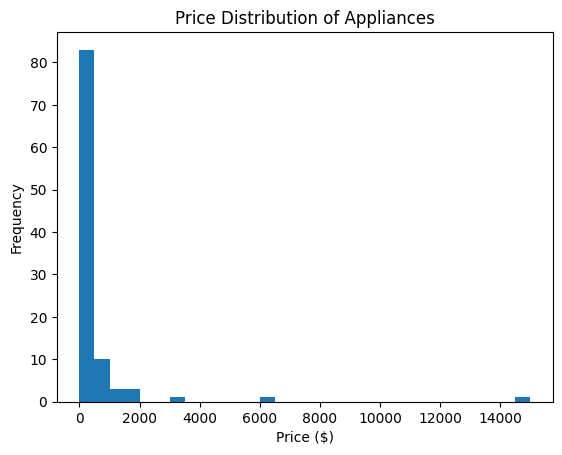

condition
used        85
new         16
like new     1
Name: count, dtype: int64


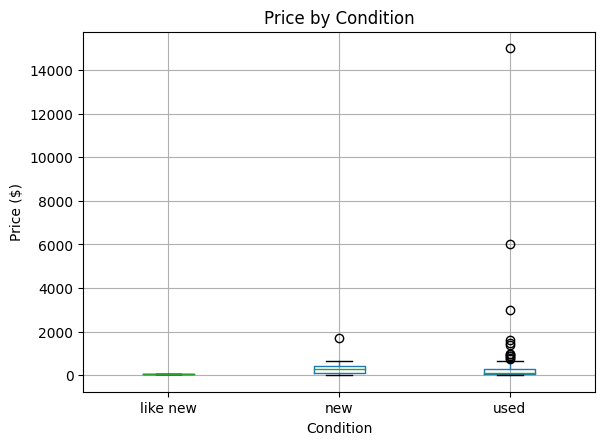

In [10]:
import matplotlib.pyplot as plt

# EDA on price
print(df['price'].describe())
df['price'].hist(grid=False, bins=30)
plt.title('Price Distribution of Appliances')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.show()

if 'condition' in df.columns:
    print(df['condition'].value_counts())
    df.boxplot(column='price', by='condition')
    plt.title('Price by Condition')
    plt.suptitle('')
    plt.xlabel('Condition')
    plt.ylabel('Price ($)')
    plt.show()

if 'type' in df.columns:
    print(df['type'].value_counts())
    df['type'].value_counts().plot(kind='bar')
    plt.title('Count of Appliance Types')
    plt.xlabel('Type of Appliance')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()